In [2]:
!pip install yfinance ta scikit-learn matplotlib seaborn plotly


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=171315d6054508d3a32d9b286202050eda47570e72bd725d921b153b41931b3f
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import ta  # Technical Analysis library

# Optional: suppress warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


In [4]:
# Define the ticker and the data period
ticker = 'AAPL'
data = yf.download(ticker, period='6mo', interval='1d')

# Check if data is fetched
if data.empty:
    raise ValueError("No data fetched. Check the ticker, period, or your network connection.")

data.dropna(inplace=True)  # Remove any rows with missing values
print(f"Fetched {len(data)} rows for {ticker}")
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Fetched 125 rows for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-10-10,228.537018,228.996014,226.671129,227.279790,28183500
2024-10-11,227.050293,228.906209,226.840747,228.796450,31759200
2024-10-14,230.792053,231.221102,228.097986,228.197757,39882100
2024-10-15,233.336456,236.968462,231.859696,233.096978,64751400
2024-10-16,231.270996,231.610246,229.335254,231.091399,34082200


In [5]:
# Calculate technical indicators using the ta library and flatten the output

# Make sure data['Close'] is a Series (it usually is, but .squeeze() ensures 1D)
close_series = data['Close'].squeeze()

# Calculate and flatten the outputs before creating a Series aligned with the index
sma_values = ta.trend.sma_indicator(close_series, window=20).values.flatten()
ema_values = ta.trend.ema_indicator(close_series, window=20).values.flatten()
rsi_values = ta.momentum.rsi(close_series, window=14).values.flatten()

# Assign back to the DataFrame, ensuring the index is preserved
data['SMA_20'] = pd.Series(sma_values, index=data.index)
data['EMA_20'] = pd.Series(ema_values, index=data.index)
data['RSI_14'] = pd.Series(rsi_values, index=data.index)

# Drop any rows with NaN values that may have been created by the indicator calculations
data.dropna(inplace=True)

print("Technical indicators added.")
data.head()


Technical indicators added.


Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI_14
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2024-11-06,222.230896,225.573545,220.704257,222.121137,54561100,229.490916,227.827766,33.818547
2024-11-07,226.980438,227.379569,224.076840,224.136706,42137700,229.413087,227.747068,47.217863
2024-11-08,226.710739,228.408869,226.161340,226.920500,38328800,229.396109,227.648370,46.640404
2024-11-11,223.983734,225.452121,221.256737,224.752893,42005600,229.055693,227.299357,41.159236
2024-11-12,223.983734,225.342241,223.114694,224.303390,40398300,228.588057,226.983584,41.159236


In [6]:
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    name='Candlestick'
))

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['SMA_20'],
    mode='lines',
    name='SMA 20'
))

fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_20'],
    mode='lines',
    name='EMA 20'
))

fig.update_layout(
    title=f"{ticker} Price Chart with Technical Indicators",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    xaxis_rangeslider_visible=False,
    height=600
)

fig.show()


In [7]:
# Create a new target column: next day’s close
data['Target'] = data['Close'].shift(-1)

# Drop the last row as it will have a missing Target
data = data.dropna()

# Select features and label
features = data[['Open', 'High', 'Low', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14']]
label = data['Target']

print(f"Features shape: {features.shape}, Label shape: {label.shape}")
data.tail()


Features shape: (105, 7), Label shape: (105,)


Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI_14,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2025-04-03,203.190002,207.490005,201.250000,205.539993,103419000,219.100001,221.219391,31.944881,188.380005
2025-04-04,188.380005,199.880005,187.339996,193.889999,125910900,216.565501,218.091830,25.191244,181.460007
2025-04-07,181.460007,194.149994,174.619995,177.199997,160466300,214.264501,214.603085,22.769009,172.419998
2025-04-08,172.419998,190.339996,169.210007,186.699997,120859500,211.843501,210.585648,20.055960,198.850006
2025-04-09,198.850006,200.610001,171.889999,171.949997,184067400,210.937002,209.467968,41.866014,188.425003


In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, shuffle=False)
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (84, 7) (84,)
Testing set: (21, 7) (21,)


In [9]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Random Forest model trained!")


Random Forest model trained!


In [10]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 440.65
R² Score: -0.98


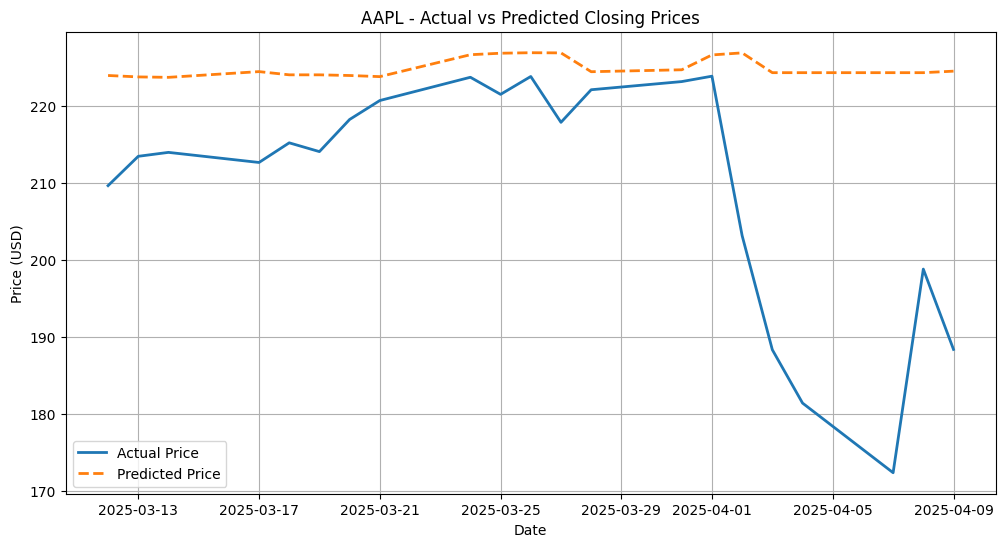

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Price', linestyle='--', linewidth=2)
plt.title(f"{ticker} - Actual vs Predicted Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Use the last available data point from the features
latest_features = features.iloc[-1].values.reshape(1, -1)
next_day_prediction = model.predict(latest_features)[0]
print(f"Predicted next closing price for {ticker}: ${next_day_prediction:.2f}")


Predicted next closing price for AAPL: $224.54
